<h2 style='color:blue;'>Project:Potato Disease Classification</h2>

### Import all the Dependencies

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [54]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=3

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: 
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potatoes",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3261 files belonging to 3 classes.


In [8]:
class_names=dataset.class_names
class_names

['Early_Blight', 'Healthy', 'Late_Blight']

In [10]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 2 1 0 0 0 1 0 1 0 0 2 2 1 0 2 0 2 0 1 2 2 1 0 0 0 2 1 1 2]


### Visualize some of the images from our dataset

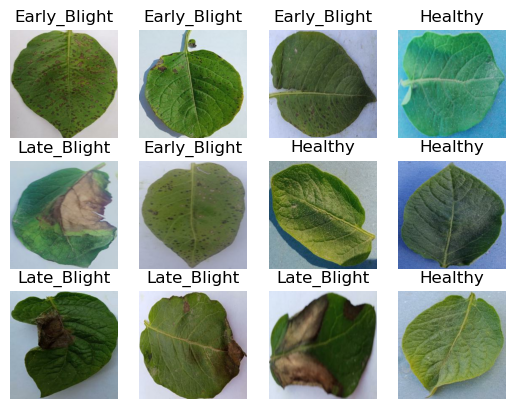

In [14]:
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

#### Function to Split Dataset


In [15]:
len(dataset)

102

In [18]:
train_size=0.8
len(dataset)*train_size

81.60000000000001

In [19]:
train_ds=dataset.take(81)
len(train_ds)

81

In [20]:
test_ds=dataset.skip(81)
len(test_ds)

21

In [22]:
val_size=0.1
len(dataset)*val_size

10.200000000000001

In [23]:
val_ds = test_ds.take(10)
len(val_ds)

10

In [24]:
test_ds = test_ds.skip(10)
len(test_ds)

11

In [25]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [26]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [27]:
len(train_ds)

81

In [28]:
len(test_ds)

11

In [29]:
len(val_ds)

10

### Cache, Shuffle, and Prefetch the Dataset

In [30]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model


#### Creating a Layer for Resizing and Normalization

In [31]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation


In [32]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [33]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture

In [34]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model

In [36]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [44]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=3,
)


Epoch 1/3
81/81 [==============================] - 218s 3s/step - loss: 0.0671 - accuracy: 0.9741 - val_loss: 0.0545 - val_accuracy: 0.9875
Epoch 2/3
81/81 [==============================] - 220s 3s/step - loss: 0.0572 - accuracy: 0.9826 - val_loss: 0.0486 - val_accuracy: 0.9781
Epoch 3/3
81/81 [==============================] - 220s 3s/step - loss: 0.0518 - accuracy: 0.9838 - val_loss: 0.0331 - val_accuracy: 0.9906


In [45]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 9s 839ms/step - loss: 0.0390 - accuracy: 0.9886


In [46]:
scores

[0.038985010236501694, 0.9886363744735718]

### Plotting the Accuracy and Loss Curves

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [47]:
history.params

{'verbose': 1, 'epochs': 3, 'steps': 81}

In [49]:
len(history.history['loss'])


3

In [51]:
history.history['loss'][:3] # show loss for first 3 epochs

[0.06713112443685532, 0.05722285062074661, 0.051808226853609085]

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

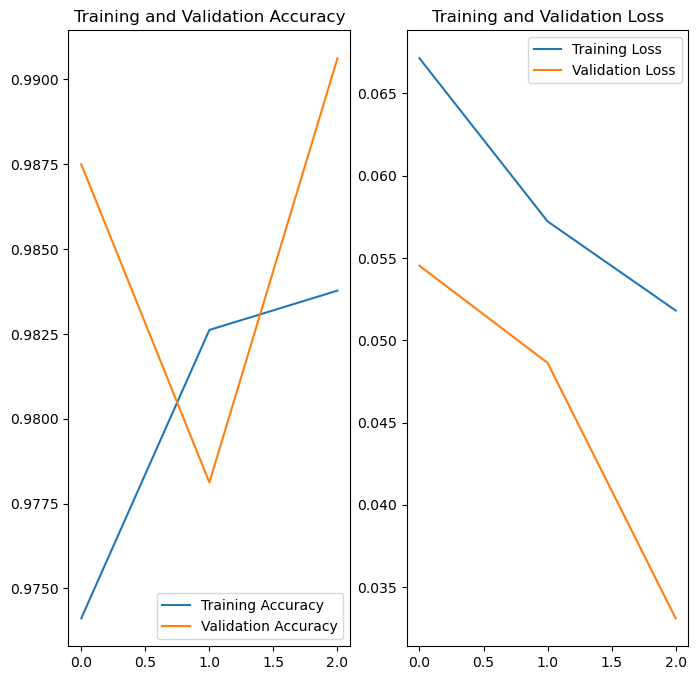

In [55]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Late_Blight
1/1 [==============================] - 1s 1s/step
predicted label: Late_Blight


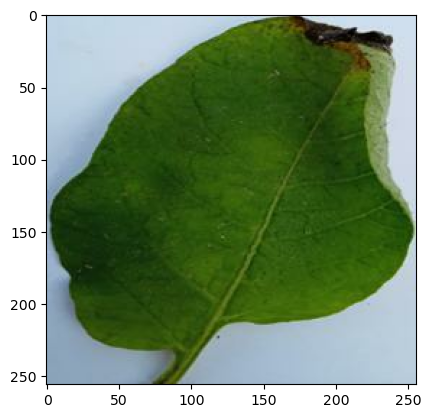

In [56]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [57]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Now run inference on few sample images

1/1 [==============================] - 0s 104ms/step


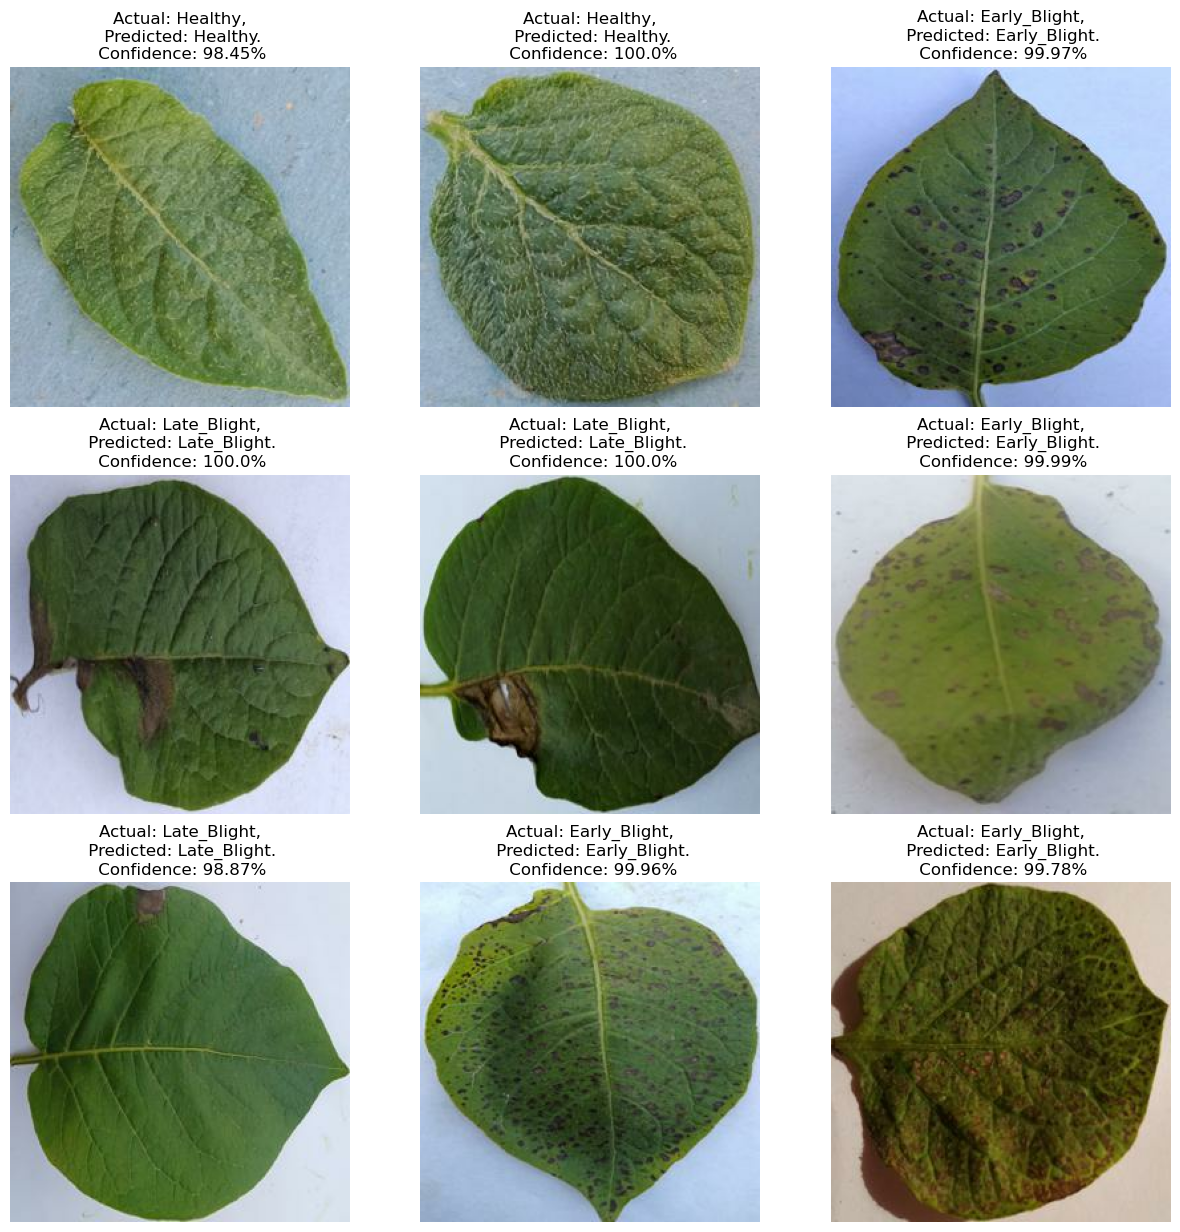

In [58]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model

In [72]:
model_version=1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets


In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")
# it will create versions,

In [ ]:
# or you can save like this
# Save the model to an .h5 file
model.save('model.h5')